<a href="https://colab.research.google.com/github/garvika40/Big_data_lab/blob/A_5/202318061_BD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Roll Number:** 202318061  
**Name:** Garvika


1. Setup and Data Preparation

● Install and configure PySpark in your environment.

● Initialize a Spark session and load the Online News Popularity dataset into a PySpark DataFrame.

● Familiarize yourself with the dataset's structure and types of variables available.

In [ ]:
!pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=80066aad981dfee2f03e07d5052789bcc72bccd80d23a0d6eb4054358a0b71a5
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession

In [ ]:
#Spark session
spark = SparkSession.builder \
    .appName("OnlineNewsPopularity") \
    .getOrCreate()

In [ ]:
df = spark.read.csv("/content/OnlineNewsPopularity.csv", header=True, inferSchema=True)
df.printSchema()

root
 |-- url: string (nullable = true)
 |--  timedelta: double (nullable = true)
 |--  n_tokens_title: double (nullable = true)
 |--  n_tokens_content: double (nullable = true)
 |--  n_unique_tokens: double (nullable = true)
 |--  n_non_stop_words: double (nullable = true)
 |--  n_non_stop_unique_tokens: double (nullable = true)
 |--  num_hrefs: double (nullable = true)
 |--  num_self_hrefs: double (nullable = true)
 |--  num_imgs: double (nullable = true)
 |--  num_videos: double (nullable = true)
 |--  average_token_length: double (nullable = true)
 |--  num_keywords: double (nullable = true)
 |--  data_channel_is_lifestyle: double (nullable = true)
 |--  data_channel_is_entertainment: double (nullable = true)
 |--  data_channel_is_bus: double (nullable = true)
 |--  data_channel_is_socmed: double (nullable = true)
 |--  data_channel_is_tech: double (nullable = true)
 |--  data_channel_is_world: double (nullable = true)
 |--  kw_min_min: string (nullable = true)
 |--  kw_max_min: do

2. Data Preprocessing

● Perform data cleaning, including dealing with missing values and any irrelevant features.

● Since the dataset contains URL data as non-predictive, ensure this is excluded from your analysis.


● Convert the dataset's target variable (shares) into a binary outcome for classification (popular vs. not
popular) based on a threshold you define (e.g., median value).

In [ ]:
data = df.drop("url")
data = data.dropna()
median_shares = data.approxQuantile(" shares", [0.5], 0.01)[0]
data = data.withColumn("popularity", (data[" shares"] >= median_shares).cast("integer"))

3. Exploratory Data Analysis (EDA)

● Conduct EDA to understand the characteristics of popular and non-popular articles.

● Analyze the distribution of key features and their impact on news popularity.

In [ ]:
#distribution of key features
data.describe().show()

+-------+------------------+------------------+------------------+-------------------+-------------------+-------------------------+------------------+------------------+-----------------+------------------+---------------------+------------------+--------------------------+------------------------------+--------------------+-----------------------+---------------------+----------------------+--------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+--------------------------+--------------------------+---------------------------+------------------+-------------------+---------------------+--------------------+-------------------+--------------------+------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+--------------------+--------------------------+---------------------------+---------------

In [ ]:
#popular and non-popular articles
data.groupBy("popularity").count().show()


+----------+-----+
|popularity|count|
+----------+-----+
|         1|12898|
|         0|11052|
+----------+-----+



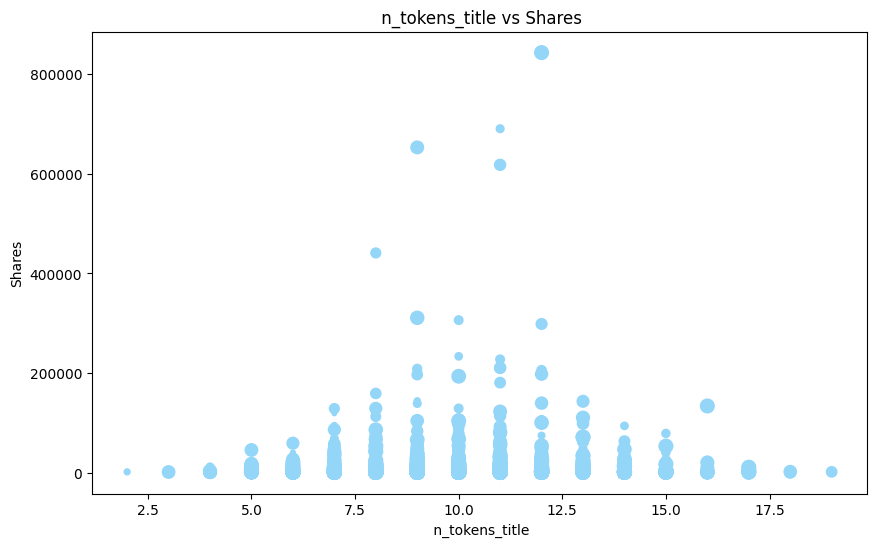

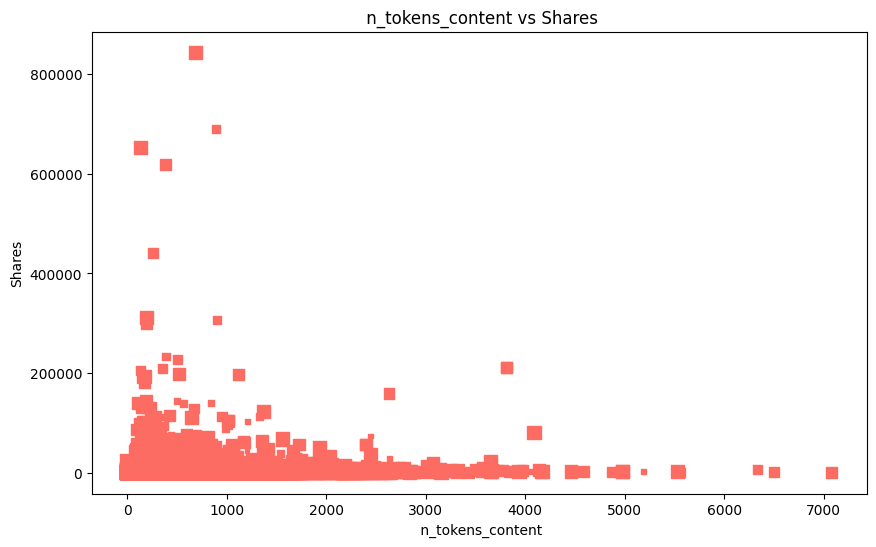

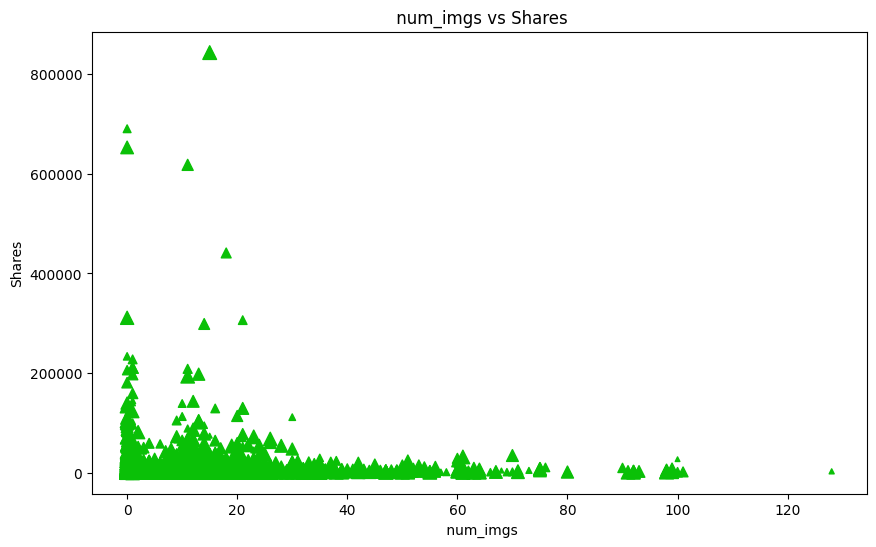

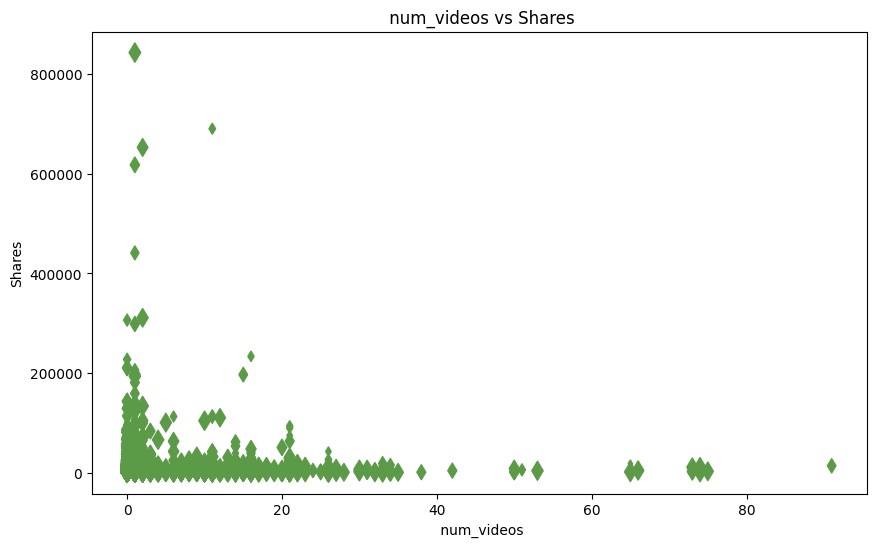

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Relationship between shares and other numerical features
numeric_features = [" n_tokens_title", " n_tokens_content", " num_imgs", " num_videos"]

# colors, sizes, and markers
colors = ['blue', 'green', 'red', 'orange']
random_sizes = np.random.randint(10, 100, size=num_rows)
markers = ['o', 's', '^', 'd']

for i, feature in enumerate(numeric_features):
    plt.figure(figsize=(10, 6))
    random_color = np.random.rand(3,)
    plt.scatter(data.toPandas()[feature], data.toPandas()[" shares"], color=random_color, s=random_sizes, marker=markers[i])
    plt.title(f"{feature.capitalize()} vs Shares")
    plt.xlabel(feature.capitalize())
    plt.ylabel("Shares")
    plt.show()


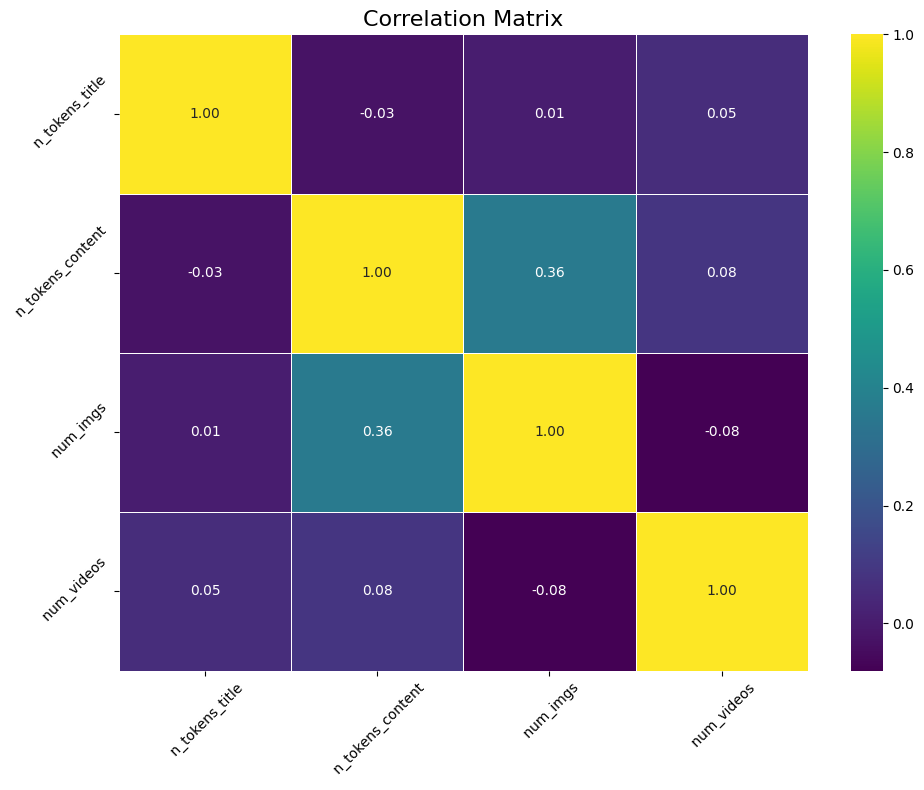

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation matrix
numeric_data = data.select(numeric_features)
correlation_matrix = numeric_data.toPandas().corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="viridis", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()



4. Feature Engineering

● Create new features that could potentially enhance model performance, such as article length
categories, weekday of publication, etc.

● Use VectorAssembler to combine all feature columns into a single vector column.

In [ ]:

from pyspark.ml.feature import Bucketizer

bucketizer = Bucketizer(splits=[0, 500, 1000, float('inf')], inputCol=" n_tokens_content", outputCol="article_length_cat")
data = bucketizer.transform(data)

5. Model Building

● Split the dataset into training and testing sets (80:20 ratio).

● Train a classification model (e.g., Logistic Regression, Decision Tree, or Random Forest) to predict
article popularity.

● Optionally, explore other algorithms and compare their performances.

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.types import StringType

# Filtering out non-numeric columns
numeric_columns = [col for col in data.columns if col not in ["shares", "popularity"] and data.schema[col].dataType != StringType()]
training_data, testing_data = data.randomSplit([0.8, 0.2], seed=42)

# feature vector
vector_assembler = VectorAssembler(inputCols=numeric_columns, outputCol="features")

# Logistic Regression model
logistic_regression = LogisticRegression(featuresCol="features", labelCol="popularity")
pipeline = Pipeline(stages=[vector_assembler, logistic_regression])

# Fitting the model on training data
model = pipeline.fit(training_data)


6. Model Evaluation

● Evaluate the model's performance using metrics such as accuracy, precision, recall, F1 score, and
AUC-ROC.

● Analyze the confusion matrix to understand the model's strengths and weaknesses.

In [ ]:
# Make predictions
predictions = model.transform(testing_data)

# Evaluatation
from pyspark.ml.evaluation import BinaryClassificationEvaluator
eval = BinaryClassificationEvaluator(labelCol="popularity")
accuracy = eval.evaluate(predictions)
print("Accuracy score:", accuracy)
predictions.groupBy("popularity", "prediction").count().show()

Accuracy score: 0.9999148277618005
+----------+----------+-----+
|popularity|prediction|count|
+----------+----------+-----+
|         1|       0.0|    1|
|         0|       0.0| 2193|
|         1|       1.0| 2513|
|         0|       1.0|    2|
+----------+----------+-----+



7. Advanced Analysis (Optional)

● Perform feature importance analysis to identify the most influential features for predicting news
popularity.

● Explore advanced techniques like model tuning and ensemble methods to improve prediction
accuracy.

In [ ]:
# Feature importance analysis
coefficients = model.stages[-1].coefficients
feature_importance = [(numeric_columns[i], coefficients[i]) for i in range(len(numeric_columns))]
print("Feature Importance:")
for feature, importance in feature_importance:
    print(feature, importance)

Feature Importance:
 timedelta -0.0021572767646919956
 n_tokens_title 0.406152770884137
 n_tokens_content -0.000757632138122104
 n_unique_tokens -6.876309644922993
 n_non_stop_words -122.55883540633755
 n_non_stop_unique_tokens 12.555365475195382
 num_hrefs -0.021759533178429696
 num_self_hrefs -0.08539653902571838
 num_imgs 0.10690894115132306
 num_videos 0.14050671122351552
 average_token_length 7.52849044337848
 num_keywords 0.22103015321648836
 data_channel_is_lifestyle -15.21676575680802
 data_channel_is_entertainment -5.571755235104949
 data_channel_is_bus -15.88461392226238
 data_channel_is_socmed -12.42440841016427
 data_channel_is_tech -14.996820989603096
 data_channel_is_world -17.5608123771828
 kw_max_min -0.00015056465364159235
 kw_avg_min -0.006267333856464892
 kw_min_max 5.338640086415115e-06
 kw_max_max 3.8400537525905825e-06
 kw_avg_max -7.550452228267753e-07
 kw_min_avg 0.003063886579645561
 kw_max_avg 0.0023979810361320977
 kw_avg_avg -0.008901827930371527
 self_refer

In [ ]:
# Grid search
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.5,0.01, 0.001]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=param_grid,
                          evaluator=eval,
                          numFolds=3)

#cross-validation
cv_model = crossval.fit(training_data)
best_model = cv_model.bestModel
best_accuracy = eval.evaluate(best_model.transform(testing_data))
print("Best Accuracy after tuning:", best_accuracy)

Best Accuracy after tuning: 0.9999148277618005


In [ ]:
# Example: Ensemble method (Random Forest)
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol="features", labelCol="popularity")
pipeline_rf = Pipeline(stages=[vector_assembler, rf])
model_rf = pipeline_rf.fit(training_data)
predictions_rf = model_rf.transform(testing_data)
accuracy_rf = eval.evaluate(predictions_rf)
print("Random Forest Accuracy:", accuracy_rf)

Random Forest Accuracy: 0.6971897734315151


In [ ]:
spark.stop()